<a href="https://colab.research.google.com/github/FabianaFerrente/ibis_pipeline/blob/master/dest_ibis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import cv2
import numpy as np


# Mount Google Drive
drive.mount('/content/drive')


shared_folder_path = '/content/drive/MyDrive/dest_IBIS'

# List files in the shared folder
if os.path.exists(shared_folder_path):
    files = os.listdir(shared_folder_path)
    print(f"Files in '{shared_folder_path}':")
    for file in files:
        print(file)
else:
    print(f"Folder '{shared_folder_path}' not found.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in '/content/drive/MyDrive/dest_IBIS':
ref_WL.fits
8542_20150518_163819_BB_SO_s000.fits


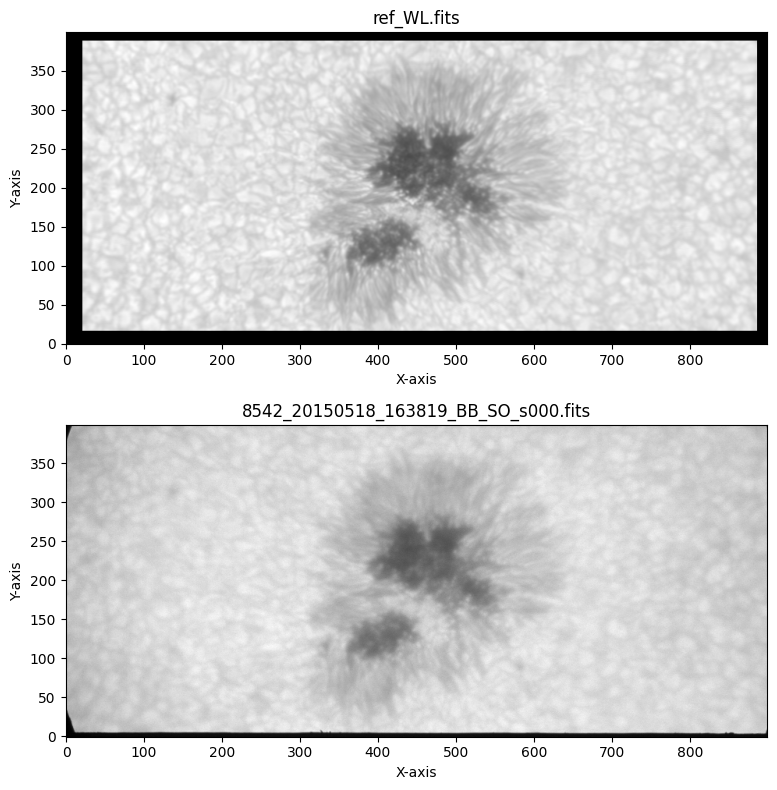

In [29]:
# Define the paths to the FITS files
fits_file_path1 = '/content/drive/MyDrive/dest_IBIS/ref_WL.fits'
fits_file_path2 = '/content/drive/MyDrive/dest_IBIS/8542_20150518_163819_BB_SO_s000.fits'

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Read and plot the first FITS file
try:
    with fits.open(fits_file_path1) as hdul:
        image_data1 = hdul[0].data
        axes[0].imshow(image_data1[300:700,50:950], origin='lower', cmap='gray',aspect='equal')
        axes[0].set_title('ref_WL.fits')
        axes[0].set_xlabel('X-axis')
        axes[0].set_ylabel('Y-axis')
except FileNotFoundError:
    print(f"Error: FITS file not found at {fits_file_path1}")
except Exception as e:
    print(f"An error occurred with {fits_file_path1}: {e}")

# Read and plot the second FITS file
try:
    with fits.open(fits_file_path2) as hdul:
        image_data2 = hdul[0].data
        axes[1].imshow(image_data2[0,300:700,50:950], origin='lower', cmap='gray', aspect='equal')
        axes[1].set_title('8542_20150518_163819_BB_SO_s000.fits')
        axes[1].set_xlabel('X-axis')
        axes[1].set_ylabel('Y-axis')
except FileNotFoundError:
    print(f"Error: FITS file not found at {fits_file_path2}")
except Exception as e:
    print(f"An error occurred with {fits_file_path2}: {e}")

plt.tight_layout()
plt.show()

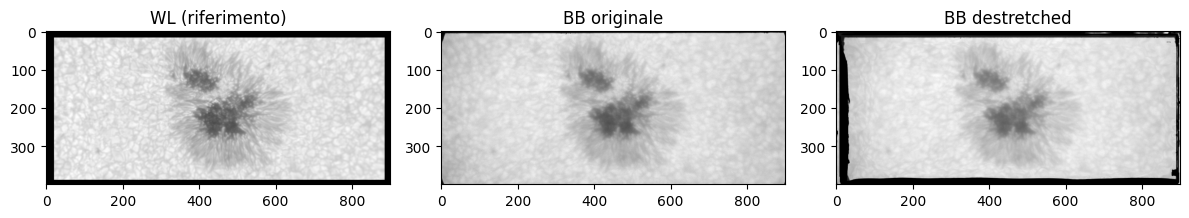

In [30]:

# Carica le immagini dal FITS
with fits.open('/content/drive/MyDrive/dest_IBIS/ref_WL.fits') as hdul:
    wl = hdul[0].data.astype(np.float32)
    wl_crop = wl[300:700, 50:950]

with fits.open('/content/drive/MyDrive/dest_IBIS/8542_20150518_163819_BB_SO_s000.fits') as hdul:
    bb_cube = hdul[0].data.astype(np.float32)
    bb = bb_cube[0, 300:700, 50:950]  # primo frame, stessa regione

# Calcola il flusso ottico tra WL e BB
flow = cv2.calcOpticalFlowFarneback(wl_crop, bb, None,
                                    pyr_scale=0.5, levels=3, winsize=15,
                                    iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

# Costruisci la mappa di rimappatura
h, w = wl_crop.shape
grid_y, grid_x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
map_x = (grid_x + flow[..., 0]).astype(np.float32)
map_y = (grid_y + flow[..., 1]).astype(np.float32)

# Applica la correzione
bb_corrected = cv2.remap(bb, map_x, map_y, interpolation=cv2.INTER_LINEAR)

# Visualizza il confronto
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("WL (riferimento)"); plt.imshow(wl_crop, cmap='gray')
plt.subplot(1,3,2); plt.title("BB originale"); plt.imshow(bb, cmap='gray')
plt.subplot(1,3,3); plt.title("BB destretched"); plt.imshow(bb_corrected, cmap='gray')
plt.tight_layout()
plt.show()
